=== PARAMÈTRES CALIBRATION ===
Dossier dataset : /kaggle/input/mire-plan-v3
Dossier sortie  : /kaggle/working/calibration_results
Taille mire (coins internes) : (13, 9)
Taille carrés (unité réelle) : 25.0

Nombre d'images trouvées : 15
 - /kaggle/input/mire-plan-v3/IMG_2070.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2084.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2061.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2057.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2083.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2085.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2060.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2074.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2057 (1).jpeg
 - /kaggle/input/mire-plan-v3/IMG_2058.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2062.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2056.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2073.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2087.jpeg
 - /kaggle/input/mire-plan-v3/IMG_2075.jpeg

=== DÉTECTION DES COINS ===
[1/15] IMG_2070.jpeg -> mire détectée : True
[2/15] IMG_2084.jpeg -> mi

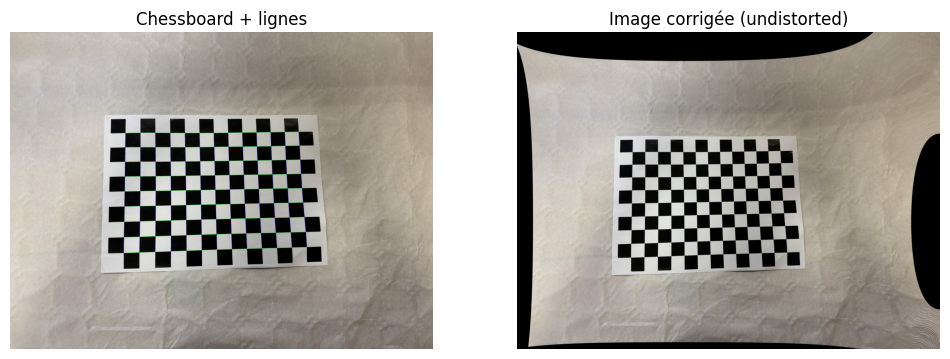

In [6]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calibre(
    dataset_dir="/kaggle/input/mire-plan-v3",
    chessboard_size=(13, 9),   # (nb de coins internes en x, nb en y)
    square_size=25.0,         # taille d'un carré en mm (à ajuster)
    output_dir="/kaggle/working/calibration_results",
    pixel_pitch_mm=None,      # taille d'un pixel du capteur en mm (optionnel)
    show_example=True
):
    """
    Calibre la caméra à partir d'un dataset de mire et affiche :
      - infos dataset
      - matrice K
      - focale fx, fy
      - centre optique cx, cy
      - lignes sur le chessboard (une image exemple)
    """

    os.makedirs(output_dir, exist_ok=True)

    print("=== PARAMÈTRES CALIBRATION ===")
    print("Dossier dataset :", dataset_dir)
    print("Dossier sortie  :", output_dir)
    print("Taille mire (coins internes) :", chessboard_size)
    print("Taille carrés (unité réelle) :", square_size)
    print()

    # 1) Récupérer toutes les images
    image_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.tiff", "*.bmp"):
        image_paths.extend(glob.glob(os.path.join(dataset_dir, "**", ext), recursive=True))

    print("Nombre d'images trouvées :", len(image_paths))
    for p in image_paths:
        print(" -", p)

    if len(image_paths) == 0:
        raise RuntimeError("Aucune image trouvée dans le dataset.")

    # 2) Préparation des points 3D / 2D
    cols, rows = chessboard_size  # attention: (x, y)
    objp = np.zeros((cols * rows, 3), np.float32)
    objp[:, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2)
    objp *= square_size

    objpoints = []
    imgpoints = []
    image_size = None

    # 3) Détection des coins pour chaque image
    print("\n=== DÉTECTION DES COINS ===")
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"[{i+1}] Impossible de lire {img_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if image_size is None:
            image_size = (gray.shape[1], gray.shape[0])  # (w, h)

        ret, corners = cv2.findChessboardCorners(
            gray,
            chessboard_size,
            flags=cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
        )

        print(f"[{i+1}/{len(image_paths)}] {os.path.basename(img_path)} -> mire détectée : {ret}")

        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS +
                        cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners2 = cv2.cornerSubPix(
                gray, corners, (11, 11), (-1, -1), criteria
            )

            objpoints.append(objp)
            imgpoints.append(corners2)

            # Image debug avec coins
            img_visu = img.copy()

            # Lignes horizontales et verticales sur la mire
            # corners2 est de dimension (cols*rows, 1, 2)
            c = corners2.reshape(-1, 2)

            # Lignes horizontales (par lignes de la mire)
            for r in range(rows):
                row_points = c[r*cols:(r+1)*cols]
                for k in range(cols - 1):
                    p1 = tuple(row_points[k].astype(int))
                    p2 = tuple(row_points[k+1].astype(int))
                    cv2.line(img_visu, p1, p2, (0, 255, 0), 2)

            # Lignes verticales (par colonnes de la mire)
            for col in range(cols):
                col_points = c[col::cols]
                for k in range(rows - 1):
                    p1 = tuple(col_points[k].astype(int))
                    p2 = tuple(col_points[k+1].astype(int))
                    cv2.line(img_visu, p1, p2, (255, 0, 0), 2)

            debug_path = os.path.join(output_dir, f"debug_lines_{os.path.basename(img_path)}")
            cv2.imwrite(debug_path, img_visu)
        else:
            fail_dir = os.path.join(output_dir, "failed")
            os.makedirs(fail_dir, exist_ok=True)
            cv2.imwrite(os.path.join(fail_dir, os.path.basename(img_path)), img)

    print("\nNombre d'images valides pour la calibration :", len(objpoints))
    if len(objpoints) < 3:
        raise RuntimeError("Pas assez d'images valides (min ~3).")

    # 4) Calibration
    print("\n=== CALIBRATION ===")
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, image_size, None, None
    )

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]

    print("\nErreur moyenne de reprojection (pixels) :", ret)
    print("\nMatrice interne K :\n", K)
    print("\nFocale fx (pixels) :", fx)
    print("Focale fy (pixels) :", fy)
    print("Centre optique cx, cy (pixels) :", cx, cy)

    if pixel_pitch_mm is not None:
        f_mm_x = fx * pixel_pitch_mm
        f_mm_y = fy * pixel_pitch_mm
        print(f"\nAvec un pixel de {pixel_pitch_mm} mm :")
        print("Focale fx (mm) :", f_mm_x)
        print("Focale fy (mm) :", f_mm_y)

    print("\nCoefficients de distorsion :\n", dist.ravel())

    # Sauvegarde
    np.savez(os.path.join(output_dir, "calibration_result.npz"),
             K=K, dist=dist, rvecs=rvecs, tvecs=tvecs,
             error=ret, chessboard_size=chessboard_size,
             square_size=square_size, image_size=image_size)

    print("\nParamètres sauvegardés dans :", os.path.join(output_dir, "calibration_result.npz"))

    # 5) Exemple : undistort + affichage d'une image avec lignes
    if show_example:
        example_path = image_paths[0]
        img_ex = cv2.imread(example_path)
        h, w = img_ex.shape[:2]
        newK, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))
        undist = cv2.undistort(img_ex, K, dist, None, newK)
        cv2.imwrite(os.path.join(output_dir, "example_undistorted.jpg"), undist)

        # charger une des images debug avec lignes
        debug_example = os.path.join(output_dir, f"debug_lines_{os.path.basename(example_path)}")
        if os.path.exists(debug_example):
            img_lines = cv2.imread(debug_example)
        else:
            img_lines = img_ex

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Chessboard + lignes")
        plt.axis("off")
        plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title("Image corrigée (undistorted)")
        plt.axis("off")
        plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        plt.show()

    # Retourne les éléments si tu veux les réutiliser plus tard
    return {
        "K": K,
        "dist": dist,
        "fx": fx,
        "fy": fy,
        "cx": cx,
        "cy": cy,
        "error": ret,
        "image_size": image_size
    }


# ============================
# APPEL DE LA FONCTION
# ============================

results = calibre()


In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Choisis une image
img_path = "/kaggle/input/mire-plan-v3/IMG_2087.jpeg"

# Charger et convertir
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

CHESSBOARD_SIZE = (9, 6)

ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE)

if ret:
    # Raffinement
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    
    # Dessiner les lignes
    img_lines = img.copy()
    cv2.drawChessboardCorners(img_lines, CHESSBOARD_SIZE, corners2, ret)

    
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
    plt.title("Chessboard détecté avec lignes")
    plt.axis("off")
else:
    print("Impossible de détecter la mire sur cette image")


Impossible de détecter la mire sur cette image
